In [1]:
import pandas as pd
import os
import pathlib
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

#### Data Preparation: Forest Cover Data

In [2]:
nb_path = pathlib.Path().resolve()
data_path = nb_path / 'data' / 'forest_cover'

In [3]:
data_path

WindowsPath('C:/Users/roseh/Desktop/785/forest_comp/data/forest_cover')

##### Convert forest acerage to percentage of county forest cover

In [31]:
def format_forest_cover_df(file, year):
    """Convert species acreage to percent of total country acerage and read to csv file"""
    
    df = pd.read_csv(file, na_values= '-', index_col = 'County code and name')  # read in file, replace '-' with NaN, set county name as index
    df = df.replace(',','', regex=True).astype('float')   # remove commas and convert all to float
    df.drop(df.tail(1).index,inplace=True)   # drop empty last row
    df.drop(df.head(1).index,inplace=True)   # drop unneeded first row
    
    cols = [i for i in df.columns[1:]]            # define list of column names, excluding first column
    
    df[cols] = df[cols].div(df['Total'], axis=0).multiply(100)    # convert species acerage to percent of total acreage
    df['COUNTY'] = df.index.str[8:]     # add column with just county name
    df.fillna(0,inplace=True)  # replace all NaN with 0
    
    filepath = 'C:/Users/roseh/Desktop/785/forest_comp/data/forest_cover'
    df.to_csv(os.path.join(filepath, f'{year}_forest_cover_percentage.csv'))

In [33]:
# read in 1995 forest cover dataset and apply function

file = os.path.join(data_path, '1995_forest_cover.csv')
format_forest_cover_df(file, '1995')

In [35]:
# read in 2021 forest cover dataset and apply function

file = os.path.join(data_path, '2021_forest_cover.csv')
format_forest_cover_df(file, '2021')

1995_forest_cover.csv


##### Join 1995 and 2021 forest cover percentage data to Maine county shapefiles

In [41]:
def merge_county_w_forestcover(counties,forest, year):
    """Merge forest percentage data to Maine county gdf and output to shapefile"""
    
    forest['COUNTY'] = forest['COUNTY'].str.strip()   # remove whitespace to match counties df
    
    df  = counties.merge(forest, on='COUNTY', how='left')    # merge gdf and df on matching COUNTY column
    gdf_forestcover = gpd.GeoDataFrame(df)
    
    data_path = 'C:/Users/roseh/Desktop/785/forest_comp/data/forest_cover/output'
    gdf_forestcover.to_file(os.path.join(data_path,f'forest_cover_{year}.shp'))   # read merged gdf to shapefile

In [37]:
# read in and format Maine counties shapefile

maine_data_path = nb_path / 'data' / 'maine'
file = os.path.join(maine_data_path, 'Maine_County_Boundary_Polygons_Dissolved_Feature.shp')
counties = gpd.read_file(file)

counties.drop(columns=['OBJECTID', 'GlobalID','created_us', 
                           'created_da', 'last_edite', 'last_edi_1'], inplace=True)      #drop unneeded columns from gdf
    
counties['COUNTY'] = counties['COUNTY'].str.strip()                                      #remove whitespace from strings in COUNTY column

In [38]:
# read in forest percentage dataframes
data_path = nb_path / 'data' / 'forest_cover'
forest_1995 = pd.read_csv(os.path.join(data_path,'1995_forest_cover_percentage.csv'))
forest_2021 = pd.read_csv(os.path.join(data_path,'2021_forest_cover_percentage.csv'))

In [39]:
# apply merge function to each df
merge_county_w_forestcover(counties,forest_1995,'1995')
merge_county_w_forestcover(counties,forest_2021,'2021')

C:\Users\roseh\AppData\Local\Temp\ipykernel_15896\3357415792.py:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_forestcover.to_file(os.path.join(data_path,f'forest_cover_{year}.shp'))   # read merged gdf to shapefile
C:\Users\roseh\AppData\Local\Temp\ipykernel_15896\3357415792.py:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_forestcover.to_file(os.path.join(data_path,f'forest_cover_{year}.shp'))   # read merged gdf to shapefile


In [43]:
merge_county_w_forestcover(counties,forest_2021,'2021_n')

C:\Users\roseh\AppData\Local\Temp\ipykernel_15896\861490431.py:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_forestcover.to_file(os.path.join(data_path,f'forest_cover_{year}.shp'))   # read merged gdf to shapefile


In [45]:
data_path = nb_path / 'data' / 'forest_cover' /'output'
cover_2021_n = gpd.read_file(os.path.join(data_path,'forest_cover_2021_n.shp'))

##### Join 1995 and 2021 forest cover dataframes and find difference

In [14]:
data_path = nb_path / 'data' / 'forest_cover'

In [6]:
fc_1995 = pd.read_csv(os.path.join(data_path,'1995_forest_cover_percentage.csv'))

In [7]:
fc_2021 = pd.read_csv(os.path.join(data_path,'2021_forest_cover_percentage.csv'))

In [8]:
fc_1995.columns

Index(['County code and name', 'Total', 'Jack pine', 'Red pine',
       'Eastern white pine', 'Balsam fir', 'White spruce', 'Black spruce',
       'Tamarack', 'Northern white-cedar', 'Oak', 'Northern hardwoods',
       'Lowland hardwoods', 'Cottonwood / Willow', 'Aspen', 'Birch',
       'Non stocked', 'Other', 'COUNTY'],
      dtype='object')

In [9]:
fc_2021.columns

Index(['County code and name', 'Total', 'Red pine', 'Eastern white pine',
       'Balsam fir', 'White spruce', 'Black spruce', 'Tamarack',
       'Northern white-cedar', 'Oak', 'Northern hardwoods',
       'Lowland hardwoods', 'Aspen', 'Birch', 'Balsam poplar', 'Non stocked',
       'Other', 'COUNTY'],
      dtype='object')

In [10]:
balsam_fir_diff = fc_2021['Balsam fir'] - fc_1995['Balsam fir']
oak_diff = fc_2021['Oak'] - fc_1995['Oak']
eastern_white_pine_diff = fc_2021['Eastern white pine'] - fc_1995['Eastern white pine']
aspen_diff = fc_2021['Aspen'] - fc_1995['Aspen']
county = fc_2021['COUNTY'].str.strip()

In [11]:
change_df = pd.DataFrame({'COUNTY':county, 'balsam_fir': balsam_fir_diff, 'oak': oak_diff, 
                          'eastern_white_pine': eastern_white_pine_diff, 'aspen':aspen_diff})

In [35]:
#change_df.to_csv(os.path.join(data_path,'change_df.csv'))

<AxesSubplot: >

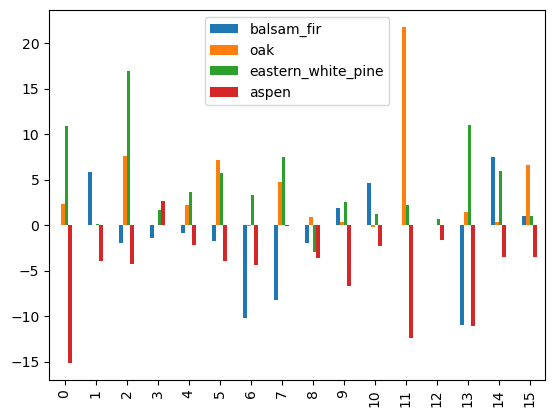

In [12]:
change_df.plot(kind='bar')

In [15]:
df  = counties.merge(change_df, on='COUNTY', how='left')    # merge gdf and df on matching COUNTY column
gdf_change_fc = gpd.GeoDataFrame(df)

In [34]:
#gdf_change_fc.to_file(os.path.join(data_path, 'change_fc.shp')

C:\Users\roseh\AppData\Local\Temp\ipykernel_15896\1232733663.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_change_fc.to_file('change_fc.shp')


In [32]:
column = gdf_change_fc['balsam_fir']
vmin, vmax = column.min(), column.max()

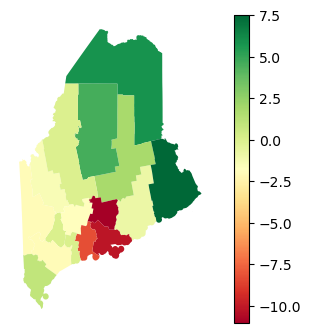

In [33]:
fig, ax = plt.subplots(1, figsize=(6,4))

gdf_change_fc.plot(column='balsam_fir', cmap='RdYlGn',ax=ax)
ax.axis('off')
ax.set_title('Change in % Forest Cover')

sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))   # create colorbar using normalized values
sm._A = []
cbar = fig.colorbar(sm, ax=plt.gca())